# **Depth Estimation**

In [ ]:
!pip install matplotlib
!pip install transforms3d
!pip install pyrender
!pip install opencv-python
!pip install open3d

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 945.1/945.1 kB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.8/704.8 kB 37.6 MB/s eta 0:00:00
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-py3-none-any.whl size=1745193 sha256=0b5f9b35768b5f3b96b2944b46148aa57de028c4552c50ef2146d1d208881e42
  Stored in directory: /root/.cache/pip/wheels/a1/3c/d2/1f9533f908d86176637521e533c6cdb2d4e48b59003b5c3f19
Successfully built PyOpenGL
  Attempting uninstall: PyOpenGL
    Found existing installation: PyOpenGL 3.1.7
    Uninstalling PyOpenGL-3.1.7:
      Successfully uninstalled PyOpenGL-3.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import cv2
from two_view_stereo.dataloader import load_middlebury_data

EPS = 1e-8

In [ ]:
!rm -rf *

# **Step 1: Load Data**

In [ ]:
!gdown "https://drive.google.com/uc?id=126-_jJtQowBRTpsNieMDTPgjDW4VYaHa"

!unzip -q two_view_stereo.zip
!chmod -R u+w two_view_stereo

Downloading...
From: https://drive.google.com/uc?id=126-_jJtQowBRTpsNieMDTPgjDW4VYaHa
To: /content/two_view_stereo.zip
100% 11.7M/11.7M [00:00<00:00, 25.3MB/s]


Loading two_view_stereo/data/templeRing


47it [00:00, 79.54it/s]


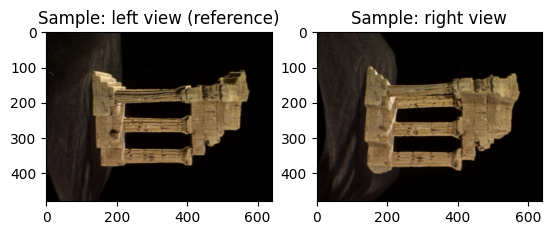

In [ ]:
DATA = load_middlebury_data("two_view_stereo/data/templeRing")

view_i, view_j = DATA[0], DATA[3]

plt.subplot(1, 2, 1)
plt.title("Sample: left view (reference)")
plt.imshow(view_i["rgb"])
plt.subplot(1, 2, 2)
plt.title("Sample: right view")
plt.imshow(view_j["rgb"])
plt.show()

# **Rectify Two Views**

### **World to Camera Transformation**

A 3D point $ P_w $ in the world coordinate system is transformed to the camera's coordinate system:
  $$
  P_i = R_{iw} \cdot P_w + T_{wi}
  $$
  - $ R_{iw} $: Rotation matrix from the world to the camera's coordinate system.
  -$ T_{wi} $: Translation vector representing the camera's position in the world.


Baseline distance between the two camera centers:
  $$
  B = \|T_{ij}\|
  $$

In [ ]:
def compute_right2left_transformation(R_iw, T_iw, R_jw, T_jw):
    """Compute the transformation that transform the coordinate from j coordinate to i

    Parameters
    ----------
    R_iw, R_jw : [3,3]
    T_iw, T_jw : [3,1]
        p_i = R_iw @ p_w + T_iw
        p_j = R_jw @ p_w + T_jw
    Returns
    -------
    [3,3], [3,1], float
        p_i = R_ij @ p_j + T_ij, B is the baseline
    """

    R_ij = R_iw @ R_jw.T
    T_ij = T_iw - R_ij @ T_jw
    B = np.linalg.norm(T_ij)

    return R_ij, T_ij, B

R_wi, T_wi = view_i["R"], view_i["T"][:, None]  # Left camera: p_i = R_wi @ p_w + T_wi
R_wj, T_wj = view_j["R"], view_j["T"][:, None]  # Right camera: p_j = R_wj @ p_w + T_wj

# R_ji: Rotation matrix from the right camera's coordinate system to the left's
# T_ji: Translation vector from the right camera to the left camera
# B: Baseline (distance between the two cameras)
R_ji, T_ji, B = compute_right2left_transformation(R_wi, T_wi, R_wj, T_wj)

Compute $ R_{\text{rect}} $ to align the epipole $ e_i $ with the y-axis $[0, 1, 0]^T$, ensuring it points to y-infinity (accounting for clockwise image rotation).


In [ ]:
# This checks that the left camera is to the left of the right camera.
assert T_ji[1, 0] > 0, "assume view i should be on the left"

# This matrix aligns the left camera's view to a "rectified" coordinate system.
R_irect = compute_rectification_R(T_ji)

[0.03301676 0.99999995 0.21269354]


Homography for both left and right images:$$
H_i = K_{i_{\text{corr}}} \cdot \left( R_{\text{irect}} \cdot K_i^{-1} \right)
$$


In [ ]:
def rectify_2view(rgb_i, rgb_j, R_irect, R_jrect, K_i, K_j, u_padding=20, v_padding=20):
    """Given the rectify rotation, compute the rectified view and corrected projection matrix

    Parameters
    ----------
    rgb_i,rgb_j : [H,W,3]
    R_irect,R_jrect : [3,3]
        p_rect_left = R_irect @ p_i
        p_rect_right = R_jrect @ p_j
    K_i,K_j : [3,3]
        original camera matrix
    u_padding,v_padding : int, optional
        padding the border to remove the blank space, by default 20

    Returns
    -------
    [H,W,3],[H,W,3],[3,3],[3,3]
        the rectified images
        the corrected camera projection matrix. WE HELP YOU TO COMPUTE K, YOU DON'T NEED TO CHANGE THIS
    """
    # reference: https://stackoverflow.com/questions/18122444/opencv-warpperspective-how-to-know-destination-image-size
    assert rgb_i.shape == rgb_j.shape, "this hw assumes the input images are in same size"
    h, w = rgb_i.shape[:2]

    ui_min, ui_max, vi_min, vi_max = homo_corners(h, w, K_i @ R_irect @ np.linalg.inv(K_i))
    uj_min, uj_max, vj_min, vj_max = homo_corners(h, w, K_j @ R_jrect @ np.linalg.inv(K_j))

    # ignore minor distortion in u direction (world vertical direction)
    w_max = int(np.floor(max(ui_max, uj_max))) - u_padding * 2
    h_max = int(np.floor(min(vi_max - vi_min, vj_max - vj_min))) - v_padding * 2

    assert K_i[0, 2] == K_j[0, 2], "this hw assumes original K has same cx"
    K_i_corr, K_j_corr = K_i.copy(), K_j.copy()
    K_i_corr[0, 2] -= u_padding
    K_i_corr[1, 2] -= vi_min + v_padding
    K_j_corr[0, 2] -= u_padding
    K_j_corr[1, 2] -= vj_min + v_padding

    H_i = K_i_corr @ (R_irect @ np.linalg.inv(K_i))
    H_j = K_j_corr @ (R_jrect @ np.linalg.inv(K_j))

    dsize = (w_max, h_max)

    rgb_i_rect = cv2.warpPerspective(rgb_i, H_i, dsize)
    rgb_j_rect = cv2.warpPerspective(rgb_j, H_j, dsize)

    return rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr

# rectify both images
# adjusts both camera views so that corresponding points in the two images are aligned
rgb_i_rect, rgb_j_rect, K_i_corr, K_j_corr = rectify_2view(
    view_i["rgb"],
    view_j["rgb"],
    R_irect,            # rectification rotation matrix for the left camera
    R_irect @ R_ji,     # rectification rotation matrix for the right camera
    view_i["K"],
    view_j["K"],
    u_padding=20,
    v_padding=20,
)

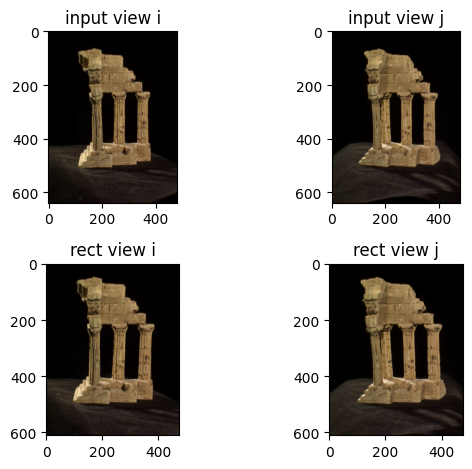

In [ ]:
plt.subplot(2, 2, 1)
plt.title("input view i")
plt.imshow(cv2.rotate(view_i["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 2)
plt.title("input view j")
plt.imshow(cv2.rotate(view_j["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 3)
plt.title("rect view i")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(2, 2, 4)
plt.title("rect view j")
plt.imshow(cv2.rotate(rgb_j_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.tight_layout()
plt.show()

# **Compute Disparity**

In [ ]:
# ensure intrinsic parameters are consistent between the two rectified images
assert K_i_corr[1, 1] == K_j_corr[1, 1], "the focal lengths in the Y direction must be the same."
assert (K_i_corr[0] == K_j_corr[0]).all(), "the intrinsic matrices must match along the X dimension."
assert (
    rgb_i_rect.shape == rgb_j_rect.shape
), "the rectified images must have the same shape (height and width)."

h, w = rgb_i_rect.shape[:2]

# compute the disparity offset
# this accounts for the difference in principal points between the two cameras
d0 = K_j_corr[1, 2] - K_i_corr[1, 2]

In [ ]:
def image2patch(image, k_size):
    """get patch buffer for each pixel location from an input image; For boundary locations, use zero padding

    Parameters
    ----------
    image : [H,W,3]
    k_size : int, must be odd number; your function should work when k_size = 1

    Returns
    -------
    [H,W,k_size**2,3]
        The patch buffer for each pixel
    """

    assert k_size % 2 == 1, "k_size must be odd"

    H, W, C = image.shape
    pad = k_size // 2

    padded_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='constant', constant_values=0)

    patch_buffer = np.zeros((H, W, k_size ** 2, C), dtype=image.dtype)
    patch_idx = 0

    for i in range(k_size):
        for j in range(k_size):
            patch_buffer[:, :, patch_idx, :] = padded_image[i:i+H, j:j+W, :]
            patch_idx += 1

    return patch_buffer  # H,W,K**2,3

# convert the images to patches for comparison
# divide pixel values by 255.0 to normalize them to the range [0, 1]
# extracts small overlapping patches of size 3x3 around each pixel
patches_i = image2patch(rgb_i_rect.astype(float) / 255.0, 3)  # patches from the left image
patches_j = image2patch(rgb_j_rect.astype(float) / 255.0, 3)  # patches from the right image

(475, 611, 9, 3)
(475, 611, 9, 3)
(475, 9, 3)


#### **Sum of Squared Differences (SSD)**
The metrics treat each RGB value as one grayscale channel. Sum across the three channels at each pixel, i.e., [H, W, 3] would go to [H, W].  
The input of each kernel function contains M left patches and N right patches.  


In [ ]:
# generate indices for the rows (v-coordinates) of the images
vi_idx, vj_idx = np.arange(h), np.arange(h)

# for each row in the left image (vi_idx), calculate potential disparity values (differences in row indices)
# add the disparity offset to adjust for the camera's principal point difference
disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0

# filter out invalid disparity values
valid_disp_mask = disp_candidates > 0.0

# compute similarity scores for a specific column u
u = 400

# extract patches for the selected column from both images
buf_i, buf_j = patches_i[:, u], patches_j[:, u]

def ssd_kernel(src, dst):
    """Compute SSD Error, the RGB channels should be treated saperately and finally summed up

    Parameters
    ----------
    src : [M,K*K,3]
        M left view patches
    dst : [N,K*K,3]
        N right view patches

    Returns
    -------
    [M,N]
        error score for each left patches with all right patches.
    """
    # src: M,K*K,3; dst: N,K*K,3
    assert src.ndim == 3 and dst.ndim == 3
    assert src.shape[1:] == dst.shape[1:]

    diff = src[:, None, :, :] - dst[None, :, :, :]
    squared_diff = diff ** 2
    ssd = squared_diff.sum(axis=2).sum(axis=2)

    return ssd  # M,N

# the smaller the SSD value, the better the match
value = ssd_kernel(buf_i, buf_j)

# _upper is a placeholder for invalid matches
_upper = value.max() + 1.0
value[~valid_disp_mask] = _upper

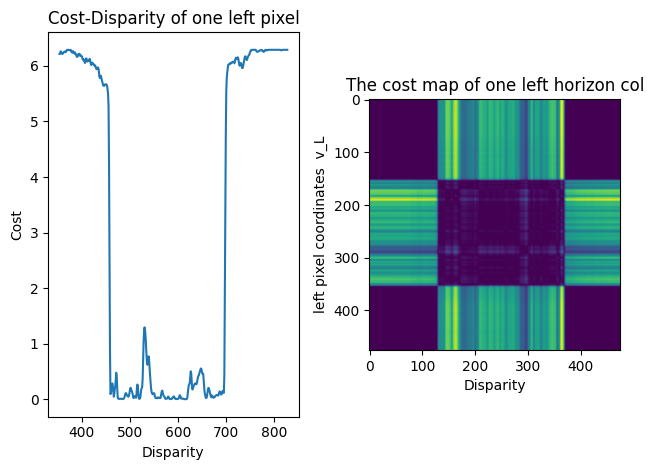

In [ ]:
plt.subplot(1,2,1)
v = 200
plt.title("Cost-Disparity of one left pixel")
plt.xlabel("Disparity")
plt.ylabel("Cost")
plt.plot(disp_candidates[v], value[v])
plt.subplot(1,2,2)
plt.title("The cost map of one left horizon col")
plt.xlabel("Disparity")
plt.ylabel("left pixel coordinates  v_L")
plt.imshow(value)
plt.tight_layout()
plt.show()

#### **Compute Disparity**

In [ ]:
def compute_disparity_map(rgb_i, rgb_j, d0, k_size=5, kernel_func=ssd_kernel):
    """Compute the disparity map from two rectified view

    Parameters
    ----------
    rgb_i,rgb_j : [H,W,3]
    d0 : see the hand out, the bias term of the disparty caused by different K matrix
    k_size : int, optional
        The patch size, by default 3
    kernel_func : function, optional
        the kernel used to compute the patch similarity, by default ssd_kernel

    Returns
    -------
    disp_map: [H,W], dtype=np.float64
        The disparity map, the disparity is defined in the handout as d0 + vL - vR

    lr_consistency_mask: [H,W], dtype=np.float64
        For each pixel, 1.0 if LR consistent, otherwise 0.0
    """

    h, w, _ = rgb_i.shape

    patches_i = image2patch(rgb_i.astype(float) / 255.0, k_size)  # Left image patches
    patches_j = image2patch(rgb_j.astype(float) / 255.0, k_size)  # Right image patches

    disp_map = np.zeros((h, w), dtype=np.float64)
    lr_consistency_mask = np.zeros((h, w), dtype=np.float64)

    for u in range(w):
        buf_i = patches_i[:, u]  # left patches for column
        buf_j = patches_j[:, u]  # right patches for column

        # similarity using kernel_func
        value = kernel_func(buf_i, buf_j)

        # increment by disparity offset
        vi_idx, vj_idx = np.arange(h), np.arange(h)
        disp_candidates = vi_idx[:, None] - vj_idx[None, :] + d0

        value[~(disp_candidates > 0.0)] = value.max() + 1.0

        best_matched_right_pixel = value.argmin(axis=1)
        disparity = d0 + np.arange(h) - best_matched_right_pixel

        disp_map[:, u] = disparity

        # lr consistency check
        for v in range(h):
            best_matched_left_pixel = value[:, best_matched_right_pixel[v]].argmin()
            consistent_flag = best_matched_left_pixel == v
            lr_consistency_mask[v, u] = 1.0 if consistent_flag else 0.0

    return disp_map.astype('float64'), lr_consistency_mask.astype('float64')

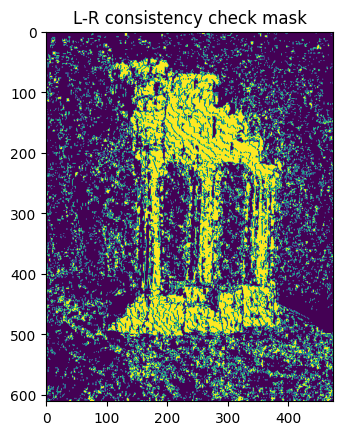

In [ ]:
disp_map, consistency_mask = compute_disparity_map(
    rgb_i_rect, rgb_j_rect, d0=K_j_corr[1, 2] - K_i_corr[1, 2], k_size=5
)

plt.imshow(cv2.rotate(consistency_mask, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.title("L-R consistency check mask")
plt.show()

# **Compute Depth Map**

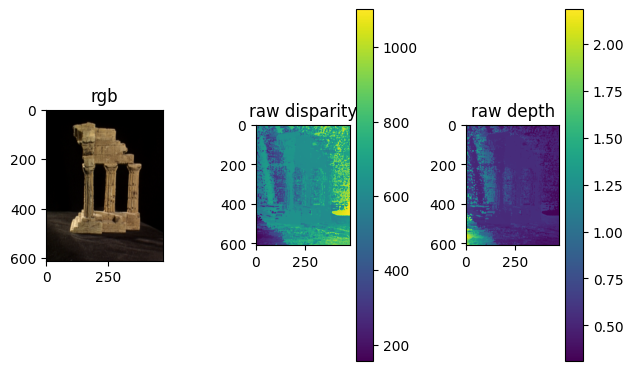

In [ ]:
from two_view_stereo.two_view_stereo import compute_dep_and_pcl

def compute_dep_and_pcl(disp_map, B, K):
    """Given disparity map d = d0 + vL - vR, the baseline and the camera matrix K
    compute the depth map and backprojected point cloud

    Parameters
    ----------
    disp_map : [H,W]
        disparity map
    B : float
        baseline
    K : [3,3]
        camera matrix

    Returns
    -------
    [H,W]
        dep_map
    [H,W,3]
        each pixel is the xyz coordinate of the back projected point cloud in camera frame
    """

    f = K[0, 0]  # focal length
    cx, cy = K[0, 2], K[1, 2]  # principal point coords

    h, w = disp_map.shape
    dep_map = np.zeros((h, w), dtype=np.float64)
    xyz_cam = np.zeros((h, w, 3), dtype=np.float64)

    dep_map = B * f / (disp_map)

    for v in range(h):
        for u in range(w):
            Z = dep_map[v, u]
            X = (u - cx) * Z / f
            Y = (v - cy) * Z / f
            xyz_cam[v, u] = [X, Y, Z]

    return dep_map, xyz_cam

dep_map, xyz_cam = compute_dep_and_pcl(disp_map, B, K_i_corr)

plt.subplot(1, 3, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(rgb_i_rect, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 3, 2)
plt.title("raw disparity")
plt.imshow(cv2.rotate(disp_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.subplot(1, 3, 3)
plt.title("raw depth")
plt.imshow(cv2.rotate(dep_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.tight_layout()
plt.show()

**Step 1 : Rectify two views** \\
I started by calculating the transformation between the right and left camera views, including the rotation matrix, translation vector, and baseline distance between the cameras. Next, I computed rectification matrices to reorient each camera’s view. Finally, I warped both images using these matrices and the cameras' intrinsic parameters. This aligned the epipolar lines across the images horizontally.

**Step 2: Compute the disparity** \\
I start by extracting small overlapping patches around each pixel in the rectified images to compare local regions between the two images for similarity. For each column in the images, I find the best match by identifying the patch pair with the smallest SSD value. The disparity is the difference in rows between the matched patches, adjusted by the offset. For each pixel in the left image, I find its best match in the right image, then reverse the process to check if the pixel in the right image matches back to the original left pixel. If this condition is satisfied, the match is considered valid. This filters out unreliable matches.

**Step 3: Compute Depth Map** \\
Using the disparity values, I compute the depth map as Z=(Baseline)*(Focal length)/(Disparity). I then back-project each pixel into 3D space using the camera model to get the X,Y,Z coordinates relative to the camera frame. This translates the 2D pixel information into 3D spatial data for scene reconstruction and depth visualization.